# Developing and training large scale neural networks (Feedforward NN and Convoluted NN) in PyTorch and geospatial visualisation of the Particulate matter 2.5 µm size concentration during a Wildfire broke out in Ventura county, USA on November 6th and 7th, 2024

In [1]:
# pip install cfgrib xarray eccodes

In [23]:
import cdsapi
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import pearsonr
import os
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

#### Downloading CAMS data

In [3]:

# Define CDS API client
client = cdsapi.Client()

variable = [
        "10m_u_component_of_wind",
        "10m_v_component_of_wind",
        "2m_temperature",
        "black_carbon_aerosol_optical_depth_550nm",
        "organic_matter_aerosol_optical_depth_550nm",
        "particulate_matter_2.5um",
        "particulate_matter_10um",
        "sulphate_aerosol_optical_depth_550nm",
        "surface_pressure",
        "total_aerosol_optical_depth_550nm"
    ]
dataset = "cams-global-reanalysis-eac4"
request = {
    "variable": variable,
    "date": ["2024-01-01/2024-12-31"],
    "time": [
        "00:00", "03:00", "06:00",
        "09:00", "12:00", "15:00",
        "18:00", "21:00"
    ],
    "data_format": "grib",
    "area": [50, -135, 25, -90]
}

# Create a filename by joining variable names with underscores (trimmed if too long)
filename = f"{'_'.join([v.replace(' ', '_') for v in variable])[:100]}.grib"

client.retrieve(dataset, request).download(filename)


2025-06-20 10:33:45,762 INFO [2025-06-16T00:00:00] CC-BY licence to replace Licence to use Copernicus Products on 02 July 2025. More information available [here](https://forum.ecmwf.int/t/cc-by-licence-to-replace-licence-to-use-copernicus-products-on-02-july-2025/13464)
2025-06-20 10:33:45,771 INFO [2025-06-10T00:00:00] To improve our CAMS service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/CruBEQ/). Thank you.
2025-06-20 10:33:45,774 INFO [2024-09-26T00:00:00] Watch our [Forum]( https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-06-20 10:33:46,052 INFO Request ID is 4dcb05ec-d6c1-4695-a3b9-015b2649dd48
2025-06-20 10:33:46,148 INFO status has been updated to accepted
2025-06-20 10:33:54,723 INFO status has been updated to running
2025-06-20 10:35:02,217 INFO status has been updated to accepted
2025-06-20 10:36:38,609 INFO status has been updated to running
2025-06-20 10:50:06,936 INFO status has been

107453ff2de8015c1f647ac494939c04.grib:   0%|          | 0.00/154M [00:00<?, ?B/s]

'10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_black_carbon_aerosol_optical_depth_55.grib'

In [2]:
print(os.path.exists("10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_black_carbon_aerosol_optical_depth_55.grib"))  # Should return True
print(os.path.getsize("10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_black_carbon_aerosol_optical_depth_55.grib"))  # Should be > 0 (not empty)

True
161051712


In [3]:
ds = xr.open_dataset('10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_black_carbon_aerosol_optical_depth_55.grib', engine='cfgrib', decode_timedelta=False)
print(list(ds.data_vars))

Ignoring index file '10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_black_carbon_aerosol_optical_depth_55.grib.5b7b6.idx' older than GRIB file


['u10', 'v10', 't2m', 'bcaod550', 'omaod550', 'pm2p5', 'pm10', 'suaod550', 'sp', 'aod550']


In [15]:
ds

<xarray.Dataset> Size: 243MB
Dimensions:     (time: 2928, latitude: 34, longitude: 61)
Coordinates:
    number      int32 4B 0
  * time        (time) datetime64[ns] 23kB 2024-01-01 ... 2024-12-31T21:00:00
    step        float64 8B 0.0
    surface     float64 8B 0.0
  * latitude    (latitude) float64 272B 49.75 49.0 48.25 ... 26.5 25.75 25.0
  * longitude   (longitude) float64 488B -135.0 -134.2 -133.5 ... -90.75 -90.0
    valid_time  (time) datetime64[ns] 23kB 2024-01-01 ... 2024-12-31T21:00:00
Data variables:
    u10         (time, latitude, longitude) float32 24MB 5.309 5.418 ... 4.656
    v10         (time, latitude, longitude) float32 24MB 2.286 1.51 ... -0.7988
    t2m         (time, latitude, longitude) float32 24MB 281.1 281.4 ... 297.8
    bcaod550    (time, latitude, longitude) float32 24MB 0.0003633 ... 0.001124
    omaod550    (time, latitude, longitude) float32 24MB 0.001984 ... 0.0158
    pm2p5       (time, latitude, longitude) float32 24MB 3.864e-09 ... 5.687e-09
    pm10        (time, latitude, longitude) float32 24MB 7.553e-09 ... 8.338e-09
    suaod550    (time, latitude, longitude) float32 24MB 0.003422 ... 0.0906
    sp          (time, latitude, longitude) float32 24MB 1.016e+05 ... 1.014e+05
    aod550      (time, latitude, longitude) float32 24MB 0.02895 ... 0.1173
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-06-21T09:59 GRIB to CDM+CF via cfgrib-0.9.1...

## Preparing a correlation matics with probable factors affecting PM2.5 concentration.

Number of rows dropped: 0


C:\Users\soura\AppData\Local\Temp\ipykernel_4160\3702315955.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot = corr_matrix.round(2).astype(str) + "\n(" + pval_matrix.applymap(lambda x: f"{x:.3f}").astype(str) + ")"


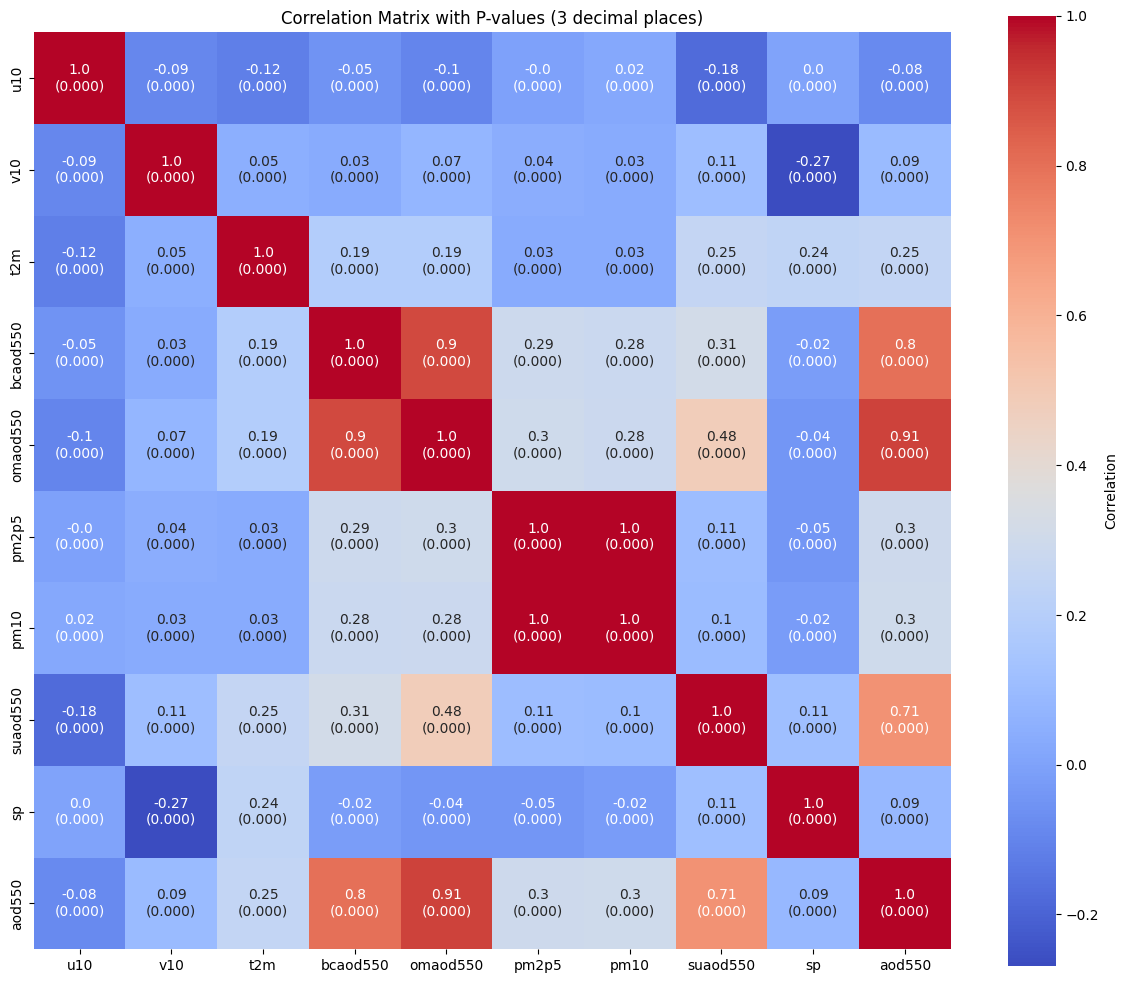

In [4]:
variables = ['u10', 'v10', 't2m', 'bcaod550', 'omaod550', 'pm2p5', 'pm10', 'suaod550', 'sp', 'aod550']

# Convert to DataFrame
df = ds.to_dataframe().reset_index()
df_clean = df[variables].dropna()
print(f"Number of rows dropped: {df.shape[0] - df_clean.shape[0]}")

# Compute correlation and p-values
corr_matrix = df_clean.corr()
pval_matrix = pd.DataFrame(np.ones((len(variables), len(variables))), columns=variables, index=variables)

for i in variables:
    for j in variables:
        if i != j:
            r, p = pearsonr(df_clean[i], df_clean[j])
            pval_matrix.loc[i, j] = p
        else:
            pval_matrix.loc[i, j] = 0.0

# Create custom annotations: corr (p)
annot = corr_matrix.round(2).astype(str) + "\n(" + pval_matrix.applymap(lambda x: f"{x:.3f}").astype(str) + ")"

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=annot, fmt='', cmap="coolwarm", square=True, cbar_kws={"label": "Correlation"})
plt.title("Correlation Matrix with P-values (3 decimal places)")
plt.tight_layout()
plt.show()


In [5]:
df_clean

,u10,v10,t2m,bcaod550,omaod550,pm2p5,pm10,suaod550,sp,aod550
0,5.308589,2.285878,281.073242,0.000363,0.001984,3.863743e-09,7.553474e-09,0.003422,101594.5000,0.028951
1,5.417964,1.510488,281.379883,0.000292,0.001589,4.162665e-09,8.135700e-09,0.004000,101609.5000,0.029713
2,5.187984,1.297597,281.703125,0.000245,0.001321,4.184397e-09,8.169884e-09,0.004476,101636.5000,0.031337
3,4.674800,1.864003,282.031250,0.000217,0.001151,3.893643e-09,7.577555e-09,0.004941,101668.0000,0.033996
4,3.972651,3.440663,282.358398,0.000206,0.001090,3.224311e-09,6.221065e-09,0.005480,101697.0000,0.037687
...,...,...,...,...,...,...,...,...,...,...
6072667,3.592915,0.165033,297.898926,0.001034,0.012813,5.468069e-09,7.882093e-09,0.073968,101389.9375,0.095545
6072668,3.850727,-0.365240,297.679199,0.001017,0.013431,5.344909e-09,7.696748e-09,0.076557,101396.9375,0.099101
6072669,4.123676,-0.601568,297.544434,0.001084,0.014934,5.814096e-09,8.369586e-09,0.080108,101398.9375,0.104883
6072670,4.433247,-0.709967,297.774902,0.001095,0.015368,5.756839e-09,8.364399e-09,0.086359,101391.9375,0.112086


## Preparing dataset for the model training

In [6]:
# Extract multiple variables
var_list = ['u10', 'v10', 't2m', 'bcaod550', 'omaod550', 'pm2p5', 'pm10', 'suaod550', 'sp', 'aod550']
data = ds[var_list]  # This is an xarray.Dataset

# Define all variables and the ones to log-transform
var_list = ['u10', 'v10', 't2m', 'bcaod550', 'omaod550', 'pm2p5', 'pm10', 'suaod550', 'sp', 'aod550']
log_vars = ['pm2p5', 'pm10']

# Apply log transformation only to selected variables
processed_vars = []
for var in var_list:
    data = ds[var]
    if var in log_vars:
        data = np.log(data + 1e-6)  # Apply log transform with epsilon
    processed_vars.append(data)

# Concatenate all processed variables along a new 'feature' dimension
data_stacked = xr.concat(processed_vars, dim='feature')  # shape: (feature, time, lat, lon)
data_np = np.moveaxis(data_stacked.values, 0, -1)        # shape: (time, lat, lon, feature)

# Convert to numpy
data_np = data_stacked.values  # shape: (feature, time, lat, lon)

# Move 'feature' to last axis if needed: (time, lat, lon, feature)
data_np = np.moveaxis(data_np, 0, -1)

# Handle case with no time dimension
if data_np.ndim == 3:  # shape: (lat, lon, feature)
    data_np = data_np[np.newaxis, :, :, :]  # add time axis

print(f"Original Data shape: {data_np.shape}")

# Normalisation
mean = data_np.mean(axis=(0, 1, 2), keepdims=True)
std = data_np.std(axis=(0, 1, 2), keepdims=True)
data_np = (data_np - mean) / std


Original Data shape: (2928, 34, 61, 10)


## Training and evaluating model performance

Training Feedforward NN...
Epoch 1 | Train Loss: 0.0049 | Val Loss: 0.0011
Epoch 2 | Train Loss: 0.0023 | Val Loss: 0.0010
Epoch 3 | Train Loss: 0.0020 | Val Loss: 0.0008
Epoch 4 | Train Loss: 0.0017 | Val Loss: 0.0008
Epoch 5 | Train Loss: 0.0015 | Val Loss: 0.0008
Epoch 6 | Train Loss: 0.0014 | Val Loss: 0.0008
Epoch 7 | Train Loss: 0.0014 | Val Loss: 0.0009
Epoch 8 | Train Loss: 0.0013 | Val Loss: 0.0007
Epoch 9 | Train Loss: 0.0013 | Val Loss: 0.0008
Epoch 10 | Train Loss: 0.0013 | Val Loss: 0.0009
Epoch 11 | Train Loss: 0.0012 | Val Loss: 0.0008
Epoch 12 | Train Loss: 0.0012 | Val Loss: 0.0008
Epoch 13 | Train Loss: 0.0012 | Val Loss: 0.0013
Epoch 14 | Train Loss: 0.0012 | Val Loss: 0.0007
Epoch 15 | Train Loss: 0.0011 | Val Loss: 0.0008
Epoch 16 | Train Loss: 0.0011 | Val Loss: 0.0007
Epoch 17 | Train Loss: 0.0011 | Val Loss: 0.0007
Epoch 18 | Train Loss: 0.0011 | Val Loss: 0.0008
Epoch 19 | Train Loss: 0.0011 | Val Loss: 0.0007
Epoch 20 | Train Loss: 0.0011 | Val Loss: 0.0010
Fe

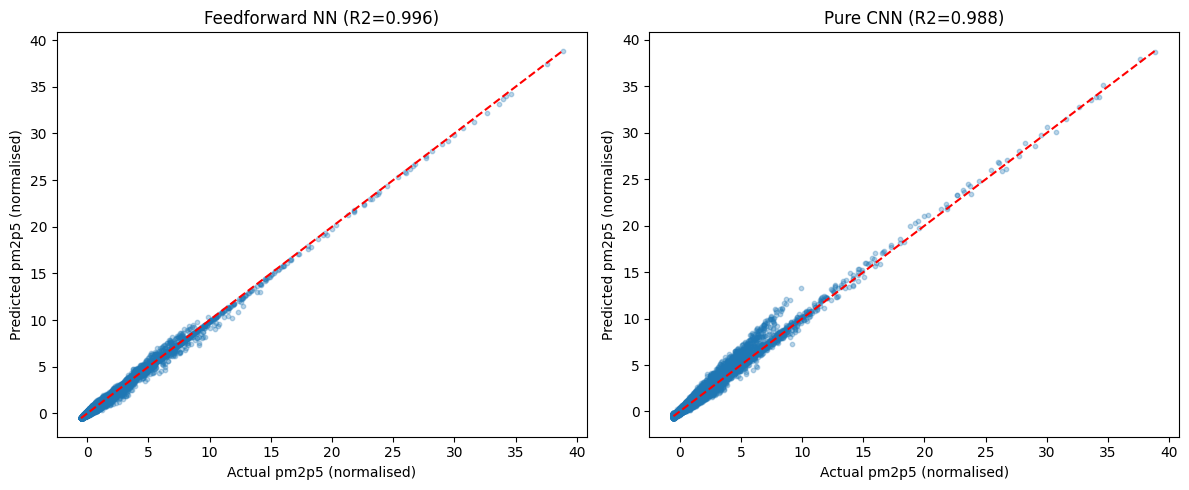

In [9]:
# Assuming data_np shape: (time, lat, lon, features)
features = ['u10', 'v10', 't2m', 'bcaod550', 'omaod550', 'pm2p5', 'pm10', 'suaod550', 'sp', 'aod550']
pm2p5_idx = features.index('pm2p5')
input_indices = [i for i in range(len(features)) if i != pm2p5_idx]

# Separate input and target
X = data_np[..., input_indices]  # shape (time, lat, lon, input_features)
y = data_np[..., pm2p5_idx]      # shape (time, lat, lon)

time_steps, lat, lon, n_features = X.shape

# Flatten spatial dimensions for CNN: treat lat*lon as sequence length
X_cnn = X.reshape(time_steps, lat*lon, n_features)  # (samples, seq_len, features)
y_cnn = y.reshape(time_steps, lat*lon)              # (samples, seq_len)

# We'll predict pm2p5 for each spatial point, so output shape = (samples, seq_len)

# Train-test split (80-20)
split = int(0.8 * time_steps)
X_train_cnn = torch.tensor(X_cnn[:split], dtype=torch.float32)
y_train_cnn = torch.tensor(y_cnn[:split], dtype=torch.float32)
X_test_cnn = torch.tensor(X_cnn[split:], dtype=torch.float32)
y_test_cnn = torch.tensor(y_cnn[split:], dtype=torch.float32)

# --------- Dataset and Dataloader ---------
class CNNDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CNNDataset(X_train_cnn, y_train_cnn)
test_dataset = CNNDataset(X_test_cnn, y_test_cnn)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# --------- Model Definitions ---------

# 1) Feedforward NN (flatten input)
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

# 2) Pure CNN Model
class PureCNN(nn.Module):
    def __init__(self, input_features):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=input_features, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(32, 16, 3, padding=1)
        self.conv_out = nn.Conv1d(16, 1, kernel_size=1)  # Predict single value per seq position

    def forward(self, x):
        # x: (batch, seq_len, features)
        x = x.permute(0, 2, 1)        # -> (batch, features, seq_len)
        x = self.relu(self.conv1(x)) # -> (batch, 32, seq_len)
        x = self.relu(self.conv2(x)) # -> (batch, 16, seq_len)
        x = self.conv_out(x)         # -> (batch, 1, seq_len)
        x = x.squeeze(1)             # -> (batch, seq_len)
        return x


# --------- Training function ---------
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        
        # Validation loss
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


# --------- Evaluation function ---------
def evaluate_model(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            y_true.append(targets.numpy().flatten())
            y_pred.append(outputs.numpy().flatten())
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    r2 = r2_score(y_true, y_pred)
    return y_true, y_pred, r2

# --------- Train and Evaluate FeedForwardNN ---------
# Flatten spatial dimension and treat all points as independent samples

X_flat = X.reshape(time_steps * lat * lon, len(input_indices))
y_flat = y.reshape(time_steps * lat * lon)

split_flat = int(0.8 * X_flat.shape[0])
X_train_ff = torch.tensor(X_flat[:split_flat], dtype=torch.float32)
y_train_ff = torch.tensor(y_flat[:split_flat], dtype=torch.float32).unsqueeze(1)
X_test_ff = torch.tensor(X_flat[split_flat:], dtype=torch.float32)
y_test_ff = torch.tensor(y_flat[split_flat:], dtype=torch.float32).unsqueeze(1)

train_dataset_ff = torch.utils.data.TensorDataset(X_train_ff, y_train_ff)
test_dataset_ff = torch.utils.data.TensorDataset(X_test_ff, y_test_ff)
train_loader_ff = DataLoader(train_dataset_ff, batch_size=64, shuffle=True)
test_loader_ff = DataLoader(test_dataset_ff, batch_size=64)

ff_model = FeedForwardNN(len(input_indices))
criterion = nn.MSELoss()
optimizer_ff = optim.Adam(ff_model.parameters(), lr=0.001)

print("Training Feedforward NN...")
train_model(ff_model, train_loader_ff, test_loader_ff, criterion, optimizer_ff, epochs=20)

y_true_ff, y_pred_ff, r2_ff = evaluate_model(ff_model, test_loader_ff)
print(f"Feedforward NN R2: {r2_ff:.4f}")

# --------- Train and Evaluate Pure CNN ---------

cnn_model = PureCNN(len(input_indices))
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)

print("\nTraining Pure CNN model...")
train_model(cnn_model, train_loader, test_loader, criterion, optimizer_cnn, epochs=20)

y_true_cnn, y_pred_cnn, r2_cnn = evaluate_model(cnn_model, test_loader)
print(f"Pure CNN R2: {r2_cnn:.4f}")

# --------- Plot actual vs predicted ---------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_true_ff, y_pred_ff, alpha=0.3, s=10)
plt.xlabel("Actual pm2p5 (normalised)")
plt.ylabel("Predicted pm2p5 (normalised)")
plt.title(f"Feedforward NN (R2={r2_ff:.3f})")
plt.plot([y_true_ff.min(), y_true_ff.max()], [y_true_ff.min(), y_true_ff.max()], 'r--')

plt.subplot(1, 2, 2)
plt.scatter(y_true_cnn, y_pred_cnn, alpha=0.3, s=10)
plt.xlabel("Actual pm2p5 (normalised)")
plt.ylabel("Predicted pm2p5 (normalised)")
plt.title(f"Pure CNN (R2={r2_cnn:.3f})")
plt.plot([y_true_cnn.min(), y_true_cnn.max()], [y_true_cnn.min(), y_true_cnn.max()], 'r--')

plt.tight_layout()

# 🔽 Save plot before showing it
plt.savefig("pm2p5_model_comparison.png", dpi=300)  # you can change dpi and file format

plt.show()



## Plotting RMSE for the feedforward NN and Convoluted NN model prediction for the next 24 hours

In [28]:
# Prepare latest input features (excluding PM2.5)
last_24_input = data_np[-24:, ..., input_indices]  # shape: (24, lat, lon, features)
last_24_pm2p5 = data_np[-24:, ..., pm2p5_idx]       # Ground truth for next 24h (shape: 24, lat, lon)

# Initialize recursive forecast input for CNN (reshape lat*lon)
X_rec_cnn = last_24_input.reshape(24, -1, len(input_indices))  # (time, seq_len, features)
y_true_24 = last_24_pm2p5.reshape(24, -1)  # Flattened ground truth

# ---------- Predict using Pure CNN ----------
cnn_model.eval()
preds_cnn = []
with torch.no_grad():
    for i in range(24):
        x_in = torch.tensor(X_rec_cnn[i:i+1], dtype=torch.float32)  # (1, seq_len, features)
        pred = cnn_model(x_in).numpy().squeeze()                    # (seq_len,)
        preds_cnn.append(pred)
preds_cnn = np.stack(preds_cnn)  # (24, seq_len)

rmse_cnn_24h = np.sqrt(np.mean((preds_cnn - y_true_24)**2))
print(f"✅ 24h RMSE (CNN): {rmse_cnn_24h:.4f}")

# ---------- Predict using Feedforward NN ----------
# Prepare flat input for last 24h
X_ff_24 = last_24_input.reshape(24 * lat * lon, len(input_indices))
y_true_ff_24 = last_24_pm2p5.reshape(24 * lat * lon)

ff_model.eval()
with torch.no_grad():
    preds_ff_24 = ff_model(torch.tensor(X_ff_24, dtype=torch.float32)).numpy().flatten()

rmse_ff_24h = np.sqrt(mean_squared_error(y_true_ff_24, preds_ff_24))
print(f"✅ 24h RMSE (Feedforward NN): {rmse_ff_24h:.4f}")


✅ 24h RMSE (CNN): 0.0517
✅ 24h RMSE (Feedforward NN): 0.0356


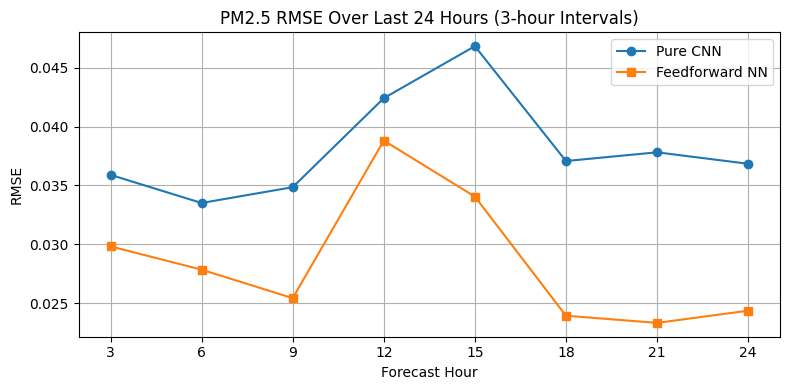

In [36]:
# Slice the last 8 timesteps
X_cnn_8 = last_24_input[-8:].reshape(8, -1, len(input_indices))  # (8, seq_len, features)
y_true_8 = last_24_pm2p5[-8:].reshape(8, -1)                     # (8, seq_len)

# ----------- CNN Predictions -----------
cnn_model.eval()
preds_cnn_8 = []
with torch.no_grad():
    for i in range(8):
        x_in = torch.tensor(X_cnn_8[i:i+1], dtype=torch.float32)
        pred = cnn_model(x_in).numpy().squeeze()
        preds_cnn_8.append(pred)
preds_cnn_8 = np.stack(preds_cnn_8)

# ----------- Feedforward NN Predictions -----------
X_ff_8 = last_24_input[-8:].reshape(8 * lat * lon, len(input_indices))
y_true_ff_8 = last_24_pm2p5[-8:].reshape(8 * lat * lon)

ff_model.eval()
with torch.no_grad():
    preds_ff_8 = ff_model(torch.tensor(X_ff_8, dtype=torch.float32)).numpy().flatten()

# Reshape FF predictions for hourly RMSE
preds_ff_reshaped_8 = preds_ff_8.reshape(8, -1)
y_true_ff_reshaped_8 = y_true_ff_8.reshape(8, -1)

# ----------- Calculate RMSEs -----------
hourly_rmse_cnn_8 = [np.sqrt(mean_squared_error(y_true_8[i], preds_cnn_8[i])) for i in range(8)]
hourly_rmse_ff_8 = [np.sqrt(mean_squared_error(y_true_ff_reshaped_8[i], preds_ff_reshaped_8[i])) for i in range(8)]

# Time axis (3-hour intervals)
hours_ahead_8 = [3 * (i + 1) for i in range(8)]  # [3, 6, ..., 24]

# ----------- Plot -----------
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(hours_ahead_8, hourly_rmse_cnn_8, marker='o', label='Pure CNN')
plt.plot(hours_ahead_8, hourly_rmse_ff_8, marker='s', label='Feedforward NN')
plt.title("PM2.5 RMSE Over Last 24 Hours (3-hour Intervals)")
plt.xlabel("Forecast Hour")
plt.ylabel("RMSE")
plt.xticks(hours_ahead_8)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("pm25_rmse_last24h.png", dpi=300)
plt.show()


## Visualization of geospatial data of particulate matter 2.5 μm distribution
#### This script is designed to visualize the spike in PM2.5 concentrations caused by the wildfire outbreak on November 6th in Ventura County, USA. The visualizations clearly indicate that on November 6th and 7th, PM2.5 levels exceeded 200 µg/m³.  

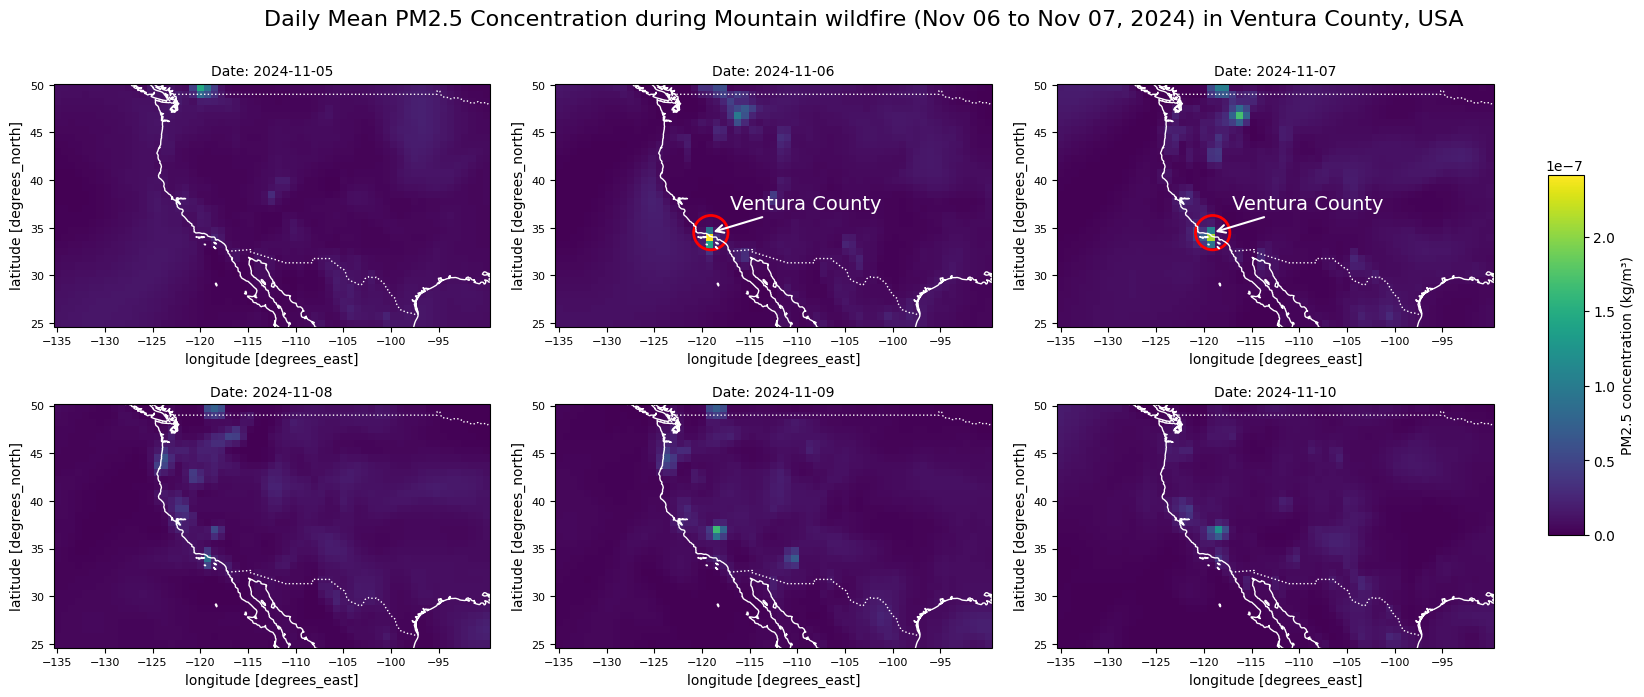

In [41]:
# Open GRIB file
#ds = xr.open_dataset('10m_u_component_of_wind_10m_v_component_of_wind_2m_temperature_black_carbon_aerosol_optical_depth_55.grib', engine='cfgrib', decode_timedelta=False)
particulate_2_5 = ds['pm2p5']

# Convert time to pandas datetime
time_values = pd.to_datetime(particulate_2_5['time'].values)

# Define date range
start_date = pd.Timestamp("2024-11-05")
end_date = pd.Timestamp("2024-11-10")

# Create a new coordinate with just the date (no time)
date_only = pd.to_datetime(particulate_2_5['time'].values).normalize()
particulate_2_5.coords['date'] = ('time', date_only)

# Filter by date range
mask = (date_only >= start_date) & (date_only <= end_date)
particulate_filtered = particulate_2_5.isel(time=np.where(mask)[0])

# Group by date and calculate daily mean
daily_mean = particulate_filtered.groupby('date').mean('time')

# Plotting
n_plots = len(daily_mean)
n_cols = 3
n_rows = int(np.ceil(n_plots / n_cols))

fig = plt.figure(figsize=(6 * n_cols, 3.6 * n_rows))
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig, hspace=0.05, wspace=0.15)  # tight vertical spacing

axes = []
for i in range(n_plots):
    ax = fig.add_subplot(gs[i], projection=ccrs.PlateCarree())
    axes.append(ax)

# Determine color scale range
vmin = float(daily_mean.min())
vmax = float(daily_mean.max())

# Define dates for highlighting the fire area
highlight_dates = ["2024-11-06", "2024-11-07"]
highlight_dates = [np.datetime64(d) for d in highlight_dates]
for i, date in enumerate(daily_mean['date'].values):
    ax = axes[i]
    da = daily_mean.sel(date=date)

    im = da.plot.pcolormesh(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap='viridis',
        vmin=vmin,
        vmax=vmax,
        add_colorbar=False
    )

    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='white', linewidth=1)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':', edgecolor='white', facecolor='none', linewidth=1)
        # Draw 50 km circle around (34.490083, -119.072804)
    if date in highlight_dates:
        center_lat = 34.490083
        center_lon = -119.072804
        radius_deg = 200 / 111.0  # Approximate conversion: 1° ≈ 111 km

        circle = plt.Circle(
            (center_lon, center_lat),
            radius_deg,
            color='red',
            fill=False,
            linewidth=2,
            transform=ccrs.PlateCarree()
        )
        ax.add_patch(circle)
        # Annotate with arrow
        ax.annotate(
            'Ventura County',
            xy=(center_lon, center_lat),
            xytext=(center_lon + 2, center_lat + 2),
            textcoords='data',
            fontsize=14,
            color='white',
            arrowprops=dict(arrowstyle="->", color='white', lw=1.5),
            ha='left',
            va='bottom',
            transform=ccrs.PlateCarree()
        )

    ax.set_xticks(np.arange(-135, -91, 5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(25, 51, 5), crs=ccrs.PlateCarree())
    ax.tick_params(labelsize=8)
    ax.set_title(f'Date: {np.datetime_as_string(date, unit="D")}', fontsize=10)

# Remove any unused subplots
# for i in range(n_plots, len(axes)):
#     fig.delaxes(axes[i])

# Adjust layout to make space for the colorbar
plt.subplots_adjust(left=0.05, right=0.85, top=0.92, bottom=0.05, hspace=0.05, wspace=0.2)  # Shrink width to make room for colorbar

# Add a colorbar to the right of all subplots
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('PM2.5 concentration (kg/m³)')

fig.suptitle('Daily Mean PM2.5 Concentration during Mountain wildfire (Nov 06 to Nov 07, 2024) in Ventura County, USA', fontsize=16)
plt.savefig("Wild_fire_visual.png", dpi=300)
plt.show()